# Data Preparation

In [1]:
# There are 2 datasets , one with 20k data and other with 200k data
# Our goal is to train on the 20k dataset and later scale it up for the other dataset (dev.text is the validation set)

In [2]:
# We're using the 20k numbers replaced dataset, lets set its path
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
# Check all the filenames in the directory
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
# Visualize examples from the data
def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list"""
    file = open(data_dir+filename,"r")
    lines = []
    # Read the lines
    for line in file:
        lines.append(line.strip())

    return lines 

In [5]:
# Save the training data as a list
train_lines = get_lines("train.txt")

In [6]:
# Check the first index in the list of sentences
train_lines[0]

'###24293578'

In [7]:
df = {} # Make a dictionary

for line in train_lines:
    if not line:
        continue
    if line[0] != "#":
        parts = line.split("\t")
        label = parts[0]
        sentence = parts[1]
        df[sentence] = label
    else:
        pass

In [8]:
# turn it into a pd DataFrame
import pandas as pd
train_df = pd.DataFrame(list(df.items()), columns = [["sentence","label"]])
train_df.head()

,sentence,label
0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE
1,A total of @ patients with primary knee OA wer...,METHODS
2,Outcome measures included pain reduction and i...,METHODS
3,Pain was assessed using the visual analog pain...,METHODS
4,Secondary outcome measures included the Wester...,METHODS


In [9]:
#Let's also import the validation data and process it
valid_lines = get_lines("dev.txt") # Save the data as a list

valid_df = {} # Make a dictionary to store the list as 2 items in a row

for line in valid_lines:
    if not line:
        continue
    if line[0] != "#":
        parts = line.split("\t")
        label = parts[0]
        sentence = parts[1]
        valid_df[sentence] = label
    else:
        pass

valid_df = pd.DataFrame(list(valid_df.items()), columns = [["sentence","label"]])
valid_df.head()

,sentence,label
0,IgE sensitization to Aspergillus fumigatus and...,BACKGROUND
1,It is not clear whether these patients would b...,BACKGROUND
2,We sought to determine whether a @-month cours...,OBJECTIVE
3,Asthmatic patients who were IgE sensitized to ...,METHODS
4,Primary outcomes were improvement in quality o...,METHODS


In [10]:
train_sentences = train_df["sentence"]
train_sentences.iloc[0]

sentence    To investigate the efficacy of @ weeks of dail...
Name: 0, dtype: object

In [11]:
train_df["label"].value_counts()

(label,)   
METHODS        58416
RESULTS        57702
CONCLUSIONS    26897
BACKGROUND     20107
OBJECTIVE      13824
Name: count, dtype: int64

In [12]:
# Finding the maximum number of words in a sentence for the whole datatset 
i = 0
words = 15
for i in range(0, len(train_sentences)):
    
    if len(str(train_sentences.iloc[i]).split()) > words:
        index = i
        words = len(str(train_sentences.iloc[i]).split())
    else:
        pass

index, words

(100044, 28)

In [13]:
# split our sentences and their respective labels into seperate numpy arrays
train_sentences = train_df["sentence"].values.ravel()
train_labels = train_df["label"].values.ravel()

valid_sentences = valid_df["sentence"].values.ravel()
valid_labels = valid_df["label"].values.ravel()

# Numerical Encoding

In [14]:
# Need to numerically encode the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)   # string -> int
valid_labels_enc = le.transform(valid_labels)

In [15]:
# Now we need to make a text_vectorizer for numerical encoding
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=70000, # How many words in our vocab
                                    standardize="lower_and_strip_punctuation", # Make it more concise
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=30,
                                    pad_to_max_tokens=True) # Pads to the end if empty

text_vectorizer.adapt(train_sentences)

In [16]:
# Let's see the some random vetcorized sentences
import random
text_vectorizer(train_sentences[random.randint(0, len(train_sentences))])

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([ 169,    5,  803,  144,    3,   96, 1338,  111,   31, 2900,    6,
         36, 6533,    6,  269, 4804, 1457,   11,   12,    7,  315,  485,
        798,    5,   56,   77,    0,    0,    0,    0], dtype=int64)>

In [17]:
# Now lets create an embedding layer and see some random embedded sentences
from tensorflow.keras import layers

embedding_layer = layers.Embedding(input_dim=70000,
                                   output_dim=128,
                                   input_length=30)

index = random.randint(0, len(train_sentences))
text_vectorizer(train_sentences[index]), embedding_layer(text_vectorizer(train_sentences[index]))

(<tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([  12,    5,   54,  487,  170,  174, 1032,   15, 3173, 8094,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int64)>,
 <tf.Tensor: shape=(30, 128), dtype=float32, numpy=
 array([[ 0.01743719,  0.00603969,  0.00238656, ..., -0.04363225,
         -0.02136405, -0.02789062],
        [ 0.01820813,  0.01497107, -0.02916775, ...,  0.01080705,
         -0.02253315, -0.02848482],
        [-0.01479319,  0.02235987,  0.01888678, ..., -0.0223353 ,
         -0.01586943, -0.03225986],
        ...,
        [-0.04178624,  0.04467532, -0.04539169, ..., -0.01630256,
          0.00520855,  0.01488927],
        [-0.04178624,  0.04467532, -0.04539169, ..., -0.01630256,
          0.00520855,  0.01488927],
        [-0.04178624,  0.04467532, -0.04539169, ..., -0.01630256,
          0.00520855,  0.01488927]], dtype=float32)>)

# Model_0 (baseline model with scikit-learn)

In [18]:
train_sentences

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'Both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'Compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( Plaque Regression With Cholesterol Abs

In [19]:
# Lets build the baseline model (Naive Bayes with TF-IDF encoder)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert the words to numbers
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [20]:
# Evaluate our baseline score
model_0_score = model_0.score(valid_sentences, valid_labels)
model_0_score

0.7208096353295417

In [21]:
model_0_preds = model_0.predict(valid_sentences)

In [22]:
# Lets make a calulation function which finds the metrics
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score,f1_score
def calculate_results(y_pred, y_true):
    model_precision = precision_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_accuracy = accuracy_score(y_pred=y_pred,y_true=y_true)
    model_recall = recall_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_f1 = f1_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_confusion = confusion_matrix(y_pred=y_pred,y_true=y_true)
    model_results = {"Model Accuracy": model_accuracy,"Model Precision":model_precision,"Model Recall":model_recall,"Model F1":model_f1,"Model Confusion Matrix":model_confusion}
    return model_results

model_0_metrics = calculate_results(model_0_preds, valid_labels)
model_0_metrics

{'Model Accuracy': 0.7208096353295417,
 'Model Precision': 0.7170592041988081,
 'Model Recall': 0.7208096353295417,
 'Model F1': 0.6970149095930861,
 'Model Confusion Matrix': array([[1476,  796,  688,   98,  186],
        [ 211, 2706,  426,    5, 1214],
        [  83,   77, 8607,    6, 1106],
        [ 507,  425,  976,  321,  147],
        [  22,  176, 1195,    1, 8435]], dtype=int64)}

# Model_1 : A simple neural network with a max pooling layer and 5 output dense neurons

In [23]:
train_labels

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [24]:
# Create a path for saving model's callbacks
model_dir = "model_logs"
 # Also import some helper functions
from helper_functions import create_tensorboard_callback

In [25]:
# Layout model_1 with the layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [26]:
# Let's compile and fit the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1_history = model_1.fit(x=train_sentences, y=train_labels_enc, epochs=5, validation_data=(valid_sentences, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_1_dense", ))

Saving TensorBoard log files to: model_logs/model_1_dense/20250914-183817
Epoch 1/5
5530/5530 [==============================] - 33s 6ms/step - loss: 0.6334 - accuracy: 0.7689 - val_loss: 0.5181 - val_accuracy: 0.8088
Epoch 2/5
5530/5530 [==============================] - 31s 6ms/step - loss: 0.4466 - accuracy: 0.8388 - val_loss: 0.5051 - val_accuracy: 0.8153
Epoch 3/5
5530/5530 [==============================] - 31s 6ms/step - loss: 0.3548 - accuracy: 0.8762 - val_loss: 0.5195 - val_accuracy: 0.8113
Epoch 4/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.2749 - accuracy: 0.9092 - val_loss: 0.5542 - val_accuracy: 0.8035
Epoch 5/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.2079 - accuracy: 0.9348 - val_loss: 0.5976 - val_accuracy: 0.7967


In [27]:
# Get the prediction probabilities of the valid data
model_1_preds = model_1.predict(valid_sentences)

935/935 [==============================] - 2s 2ms/step


In [28]:
# Turn the probabilities into labels
model_1_preds_rounded = []
for i in range(0, len(model_1_preds)):
    index = model_1_preds[i].argmax()
    model_1_preds_rounded.append(index)

In [29]:
# Let's see some metrics
model_1_metrics = calculate_results(model_1_preds_rounded, valid_labels_enc)
model_1_metrics

{'Model Accuracy': 0.7967213114754098,
 'Model Precision': 0.7966160742930337,
 'Model Recall': 0.7967213114754098,
 'Model F1': 0.7965377626851979,
 'Model Confusion Matrix': array([[1976,  426,  179,  608,   55],
        [ 432, 3366,  143,  132,  489],
        [ 141,  122, 8789,  130,  697],
        [ 681,  184,  158, 1323,   30],
        [  61,  634,  741,   33, 8360]], dtype=int64)}

# Model_2 : ConV1D Model 

In [30]:
# Layout model_2 with the layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_2 = tf.keras.Model(inputs, outputs, name="model_2_ConV_1D")

In [31]:
# Let's compile and fit the model
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history = model_2.fit(x=train_sentences, y=train_labels_enc, epochs=5, validation_data=(valid_sentences, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_2_ConV_1D", ))

Saving TensorBoard log files to: model_logs/model_2_ConV_1D/20250914-184103
Epoch 1/5
5530/5530 [==============================] - 38s 6ms/step - loss: 0.4677 - accuracy: 0.8318 - val_loss: 0.5043 - val_accuracy: 0.8138
Epoch 2/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.3015 - accuracy: 0.8954 - val_loss: 0.5456 - val_accuracy: 0.8097
Epoch 3/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.1848 - accuracy: 0.9398 - val_loss: 0.6415 - val_accuracy: 0.7977
Epoch 4/5
5530/5530 [==============================] - 35s 6ms/step - loss: 0.1043 - accuracy: 0.9674 - val_loss: 0.8126 - val_accuracy: 0.7873
Epoch 5/5
5530/5530 [==============================] - 35s 6ms/step - loss: 0.0584 - accuracy: 0.9818 - val_loss: 0.9716 - val_accuracy: 0.7776


In [32]:
# Get the prediction probabilities of the valid data
model_2_preds = model_2.predict(valid_sentences)

# Turn the probabilities into labels
model_2_preds_rounded = []
for i in range(0, len(model_2_preds)):
    index = model_2_preds[i].argmax()
    model_2_preds_rounded.append(index)

935/935 [==============================] - 2s 2ms/step


In [33]:
# Let's see some metrics
model_2_metrics = calculate_results(model_2_preds_rounded, valid_labels_enc)
model_2_metrics

{'Model Accuracy': 0.7775844764135162,
 'Model Precision': 0.7833445831344554,
 'Model Recall': 0.7775844764135162,
 'Model F1': 0.7799045652227463,
 'Model Confusion Matrix': array([[1931,  436,  162,  665,   50],
        [ 499, 3308,  120,  149,  486],
        [ 262,  177, 8636,  203,  601],
        [ 743,  151,  116, 1335,   31],
        [ 127,  807,  823,   40, 8032]], dtype=int64)}

# Model_3 : ConV1D with character embeddings 

In [34]:
train_sentences[:5]

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'],
      dtype=object)

In [35]:
# Create a character-level tokenizer
def split_chars(text):
    return " ".join(list(text))

In [36]:
split_char = split_chars("word")
split_char

'w o r d'

In [37]:
# Lets create a characted seperated word array of the train sentences
train_sentences_chars = []
valid_sentences_chars = []
for i in range(0, len(train_sentences)):
    train_sentences_chars.append(split_chars(train_sentences[i]))

for i in range(0, len(valid_sentences)):
    valid_sentences_chars.append(split_chars(valid_sentences[i]))

In [38]:
import numpy as np
train_sentences_chars = np.array(train_sentences_chars)
valid_sentences_chars = np.array(valid_sentences_chars)

In [39]:
# Lets create a character tokenizer
charactor_vectorizer = TextVectorization(max_tokens=40, # How many words in our vocab
                                    standardize="lower_and_strip_punctuation", # Make it more concise
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=290,
                                    pad_to_max_tokens=True) # Pads to the end if empty

charactor_vectorizer.adapt(train_sentences_chars)

In [40]:
(charactor_vectorizer.get_vocabulary())

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [41]:
# Lets create a character embedding layer
char_embedding = layers.Embedding(input_dim=40,
                                  output_dim=128,
                                  input_length=290)

In [42]:
# Lets see some random char-embedded sentences
i = random.randint(0, len(train_sentences_chars))

train_sentences_chars[i], char_embedding(charactor_vectorizer(train_sentences_chars[i]))

('T w o   h u n d r e d   p a t i e n t s   w i t h   a   t o t a l   o f   @   A K s   w e r e   e n r o l l e d   .',
 <tf.Tensor: shape=(290, 128), dtype=float32, numpy=
 array([[-0.00424381,  0.01534339, -0.0436782 , ...,  0.04256246,
          0.00478983, -0.02758514],
        [-0.02281387,  0.04246357, -0.02666314, ..., -0.04007772,
         -0.00135188,  0.01827884],
        [-0.03188147, -0.02734294,  0.00989804, ..., -0.01312317,
          0.01572521, -0.00476866],
        ...,
        [-0.01793636, -0.04293225,  0.0098919 , ...,  0.04251743,
          0.02291792, -0.00975095],
        [-0.01793636, -0.04293225,  0.0098919 , ...,  0.04251743,
          0.02291792, -0.00975095],
        [-0.01793636, -0.04293225,  0.0098919 , ...,  0.04251743,
          0.02291792, -0.00975095]], dtype=float32)>)

In [43]:
# Time to create model_3
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = charactor_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_3 = tf.keras.Model(inputs, outputs, name="model_3_ConV_1D_char_embedding")

In [44]:
# Let's compile and fit the model
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3_history = model_3.fit(x=train_sentences_chars, y=train_labels_enc, epochs=5, validation_data=(valid_sentences_chars, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_3_ConV_1D_char_embedding", ))

Saving TensorBoard log files to: model_logs/model_3_ConV_1D_char_embedding/20250914-184410
Epoch 1/5
5530/5530 [==============================] - 26s 5ms/step - loss: 0.8404 - accuracy: 0.6751 - val_loss: 0.7482 - val_accuracy: 0.7158
Epoch 2/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.7237 - accuracy: 0.7251 - val_loss: 0.7028 - val_accuracy: 0.7297
Epoch 3/5
5530/5530 [==============================] - 26s 5ms/step - loss: 0.6984 - accuracy: 0.7361 - val_loss: 0.6946 - val_accuracy: 0.7369
Epoch 4/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.6845 - accuracy: 0.7411 - val_loss: 0.6886 - val_accuracy: 0.7381
Epoch 5/5
5530/5530 [==============================] - 28s 5ms/step - loss: 0.6744 - accuracy: 0.7459 - val_loss: 0.6754 - val_accuracy: 0.7448


In [45]:
# Get the prediction probabilities of the valid data
model_3_preds = model_3.predict(valid_sentences_chars)

# Turn the probabilities into labels
model_3_preds_rounded = []
for i in range(0, len(model_3_preds)):
    index = model_3_preds[i].argmax()
    model_3_preds_rounded.append(index)

935/935 [==============================] - 2s 2ms/step


In [46]:
# Let's see some metrics
model_3_metrics = calculate_results(model_3_preds_rounded, valid_labels_enc)
model_3_metrics

{'Model Accuracy': 0.7447975911676146,
 'Model Precision': 0.7363554510388068,
 'Model Recall': 0.7447975911676146,
 'Model F1': 0.7361141268052065,
 'Model Confusion Matrix': array([[1139,  802,  416,  753,  134],
        [ 266, 2826,  352,  200,  918],
        [  76,  171, 8665,  148,  819],
        [ 360,  321,  280, 1350,   65],
        [  30,  375, 1115,   27, 8282]], dtype=int64)}

# Model_4 : Pretrained token embeddings + character embeddings

In [47]:
# Lets get our pretrained token embedding layer from tensorflow_hub
import tensorflow_hub as hub

embed_url = "https://tfhub.dev/google/nnlm-en-dim128/2"

tf_hub_embedding_layer = hub.KerasLayer(handle=embed_url,
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [48]:
# Train dataset
train_token_char_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input": train_sentences,
        "char_input": train_sentences_chars
    },
    train_labels_enc
))

# Validation dataset
valid_token_char_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input": valid_sentences,
        "char_input": valid_sentences_chars
    },
    valid_labels_enc
))


# Prefecth and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_token_char_dataset = valid_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
for features, label in train_token_char_dataset.take(1):
    print(features.keys())
    print(features["token_input"].shape, features["token_input"].dtype)
    print(features["char_input"].shape, features["char_input"].dtype)
    print(label.shape, label.dtype)

dict_keys(['token_input', 'char_input'])
(32,) <dtype: 'string'>
(32,) <dtype: 'string'>
(32,) <dtype: 'int32'>


In [50]:
#1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

#2. Setup the char inputs/model
char_inputs = layers.Input(shape=[1, ], dtype=tf.string, name="char_input")
char_vectors = charactor_vectorizer(char_inputs)
char_vectors = tf.cast(char_vectors, tf.int32)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

#3. Concatenate token and chart inputs
token_char_concat = layers.Concatenate(name="token_char_inputs")([token_model.output, char_model.output])

#4. Create output layers - Add a Dropout for regularization
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Create the model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_char_model")

In [51]:
# Let's visualize the model
model_4.summary()

Model: "model_4_token_char_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 290)          0           ['text_vec

In [52]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [53]:
# Let's compile and fit the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4_history = model_4.fit(x=train_token_char_dataset, epochs=5, validation_data=valid_token_char_dataset, callbacks=create_tensorboard_callback(model_dir,"model_4_hybrid_token_char_embedding", ))

Saving TensorBoard log files to: model_logs/model_4_hybrid_token_char_embedding/20250914-184631
Epoch 1/5
5530/5530 [==============================] - 210s 37ms/step - loss: 0.7465 - accuracy: 0.7167 - val_loss: 0.5965 - val_accuracy: 0.7762
Epoch 2/5
5530/5530 [==============================] - 230s 42ms/step - loss: 0.6542 - accuracy: 0.7548 - val_loss: 0.5669 - val_accuracy: 0.7861
Epoch 3/5
5530/5530 [==============================] - 208s 38ms/step - loss: 0.6305 - accuracy: 0.7641 - val_loss: 0.5560 - val_accuracy: 0.7889
Epoch 4/5
5530/5530 [==============================] - 187s 34ms/step - loss: 0.6185 - accuracy: 0.7686 - val_loss: 0.5463 - val_accuracy: 0.7925
Epoch 5/5
5530/5530 [==============================] - 188s 34ms/step - loss: 0.6080 - accuracy: 0.7728 - val_loss: 0.5400 - val_accuracy: 0.7959


In [54]:
# Get the prediction probabilities of the valid data
model_4_preds = model_4.predict((valid_sentences,valid_sentences_chars))

# Turn the probabilities into labels
model_4_preds_rounded = []
for i in range(0, len(model_4_preds)):
    index = model_4_preds[i].argmax()
    model_4_preds_rounded.append(index)

935/935 [==============================] - 15s 16ms/step


In [55]:
# Let's see some metrics
model_4_metrics = calculate_results(model_4_preds_rounded, valid_labels_enc)
model_4_metrics

{'Model Accuracy': 0.7958849113415858,
 'Model Precision': 0.796514731585822,
 'Model Recall': 0.7958849113415858,
 'Model F1': 0.7923170039291004,
 'Model Confusion Matrix': array([[2058,  570,  292,  239,   85],
        [ 454, 3172,  238,    7,  691],
        [ 155,  137, 8925,   24,  638],
        [ 820,  187,  179, 1135,   55],
        [  49,  317,  962,    2, 8499]], dtype=int64)}

# Compare Model Results with a bar plot

In [58]:
all_model_results = pd.DataFrame({
    "baseline" : model_0_metrics,
    "Model_1" : model_1_metrics,
    "Model_2" : model_2_metrics,
    "Model_3" : model_3_metrics,
    "Model_4" : model_4_metrics
})
all_model_results = all_model_results.transpose()
all_model_results

,Model Accuracy,Model Precision,Model Recall,Model F1,Model Confusion Matrix
baseline,0.72081,0.717059,0.72081,0.697015,"[[1476, 796, 688, 98, 186], [211, 2706, 426, 5..."
Model_1,0.796721,0.796616,0.796721,0.796538,"[[1976, 426, 179, 608, 55], [432, 3366, 143, 1..."
Model_2,0.777584,0.783345,0.777584,0.779905,"[[1931, 436, 162, 665, 50], [499, 3308, 120, 1..."
Model_3,0.744798,0.736355,0.744798,0.736114,"[[1139, 802, 416, 753, 134], [266, 2826, 352, ..."
Model_4,0.795885,0.796515,0.795885,0.792317,"[[2058, 570, 292, 239, 85], [454, 3172, 238, 7..."


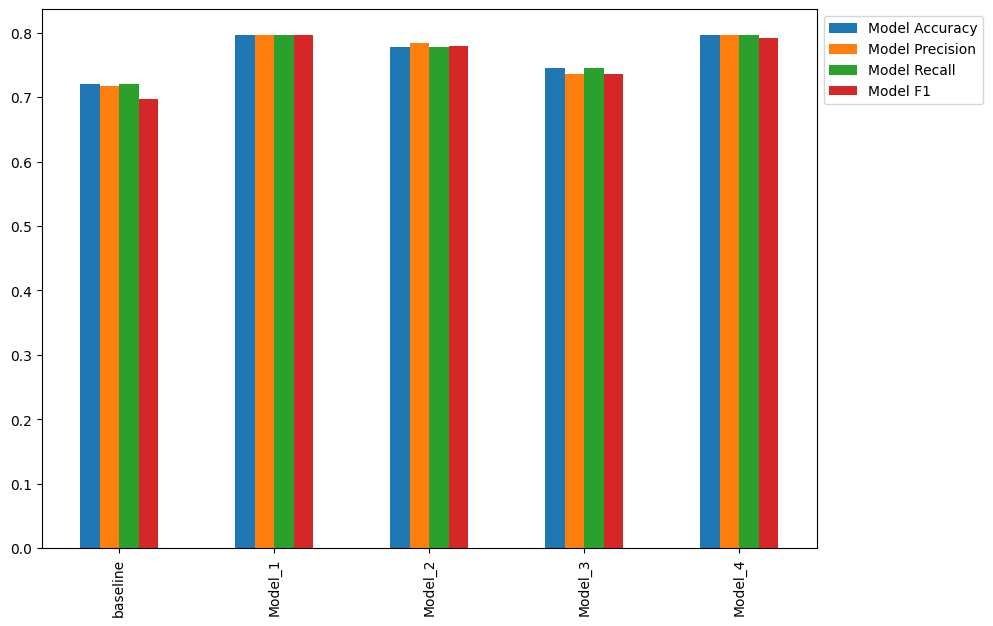

In [59]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));